In [1]:
from keras.datasets import imdb

In [3]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17473536/17464789 [==============================] - 133s 8us/step


num_words는 훈련 데이터에서 가장 많이 나타나는 단어 10000개를 사용하겠다는 뜻
각 labels에 저장된 0과 1은 0:부정 , 1:긍정으로 카테고리 변수로 사용할 수 있음

In [4]:
max([max(sequence) for sequence in train_data])

9999

In [5]:
train_data.shape

(25000,)

In [13]:
len(train_data[24999])

153

In [14]:
word_index = imdb.get_word_index()    # 단어와 정수 인덱스를 매핑한 딕셔너리
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

1654784/1641221 [==============================] - 12s 7us/step


신경망에 숫자 리스트를 넣을 수는 없다.

리스트를 텐서로 바꾸는 방법은 두 가지.

1. 같은 길이가 되도록 리스트에 패딩을 추가하고 (samples, sequence_length) 크기의 정수 텐서로 변환한다. 그다음 이 정수 텐서를 다룰 수 있는 층을 신경망의 첫 번째 층으로 사용한다.
2. 리스트를 원-핫 인코딩하여 0과 1의 벡터로 변환한다. 예를 들어 시퀀스[3,5]를 인덱스 3과 5의 위치는 1이고 나머지는 0인 10000차원의 벡터로 각각 변환한다. 그다음 부동 소수 벡터 데이터를 다룰 수 있는 Dense 층을 신경망의 첫 번째 층으로 사용한다. 

In [21]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

X_train = vectorize_sequences(train_data)
X_test = vectorize_sequences(test_data)

In [22]:
X_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [23]:
X_test[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [24]:
# 데이터를 벡터화했으니 레이블도 벡터화 해야하는데, 레이블은 01로만 이루어져있으므로 numpy asarray 사용
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

Dense 층을 쌓을 때 두 가지 중요한 구조상의 결정이 필요하다
1. 얼마나 많은 층을 사용할 것인가?
2. 각 층에 얼마나 많은 은닉 유닛을 둘 것인가?

해당 실습에서는 중간에 위치하는 은닉층은 활성화 함수로 relu를 사용, 마지막 층은 확률을 점수로 출력하기 위해 시그모이드 활성화 함수를 사용
1. relu는 음수를 0으로 만드는 함수
2. sigmoid는 0과 1 사이로 정규화하므로 출력값을 확률로 해석 가능

In [25]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Dense층의 매개변수 16은 은닉 유닛의 개수이다. 하나의 은닉 유닛은 층에 나타내는 표현 공간에서 하나의 차원이 된다. 16개의 은닉 유닛이 있다는 것은 가중치 행렬 $w$의 크기가 16차원이라는 것이다. 

model에 레이어를 만들어준 후에는,

옵티마이저와 손실함수를 정해줘야한다.

compile 메서드의 파라미터로 지정.

In [26]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSpop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 직접 옵티마이저의 매개변수를 지정해줘야하는 경우, 클래스를 직접 불러와서 값을 지정해줌

In [ ]:
from keras import losses
from keras import metrics

model.compile(optimizer='rmsprop',
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

# 손실함수나 측정함수에도 직접 값을 전달하고 싶은 경우, 클래스를 직접 불러와서 함수 객체를 전달하면 됨

# 훈련 검증
- 훈련하는 동안 처음 본 데이터에 대한 모델의 정확도를 측정하기 위해서는 원본 훈련 데이터에서 10,000의 샘플을 떼어서 검증 세트를 만들어야 함.

In [35]:
x_val = X_train[:10000]
partial_X_train = X_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [37]:
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 27ms/step - loss: 0.5012 - accuracy: 0.8035 - val_loss: 0.3769 - val_accuracy: 0.8745
Epoch 2/20
30/30 [==============================] - 0s 14ms/step - loss: 0.3015 - accuracy: 0.9013 - val_loss: 0.3038 - val_accuracy: 0.8866
Epoch 3/20
30/30 [==============================] - 0s 15ms/step - loss: 0.2189 - accuracy: 0.9297 - val_loss: 0.2760 - val_accuracy: 0.8926
Epoch 4/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1738 - accuracy: 0.9425 - val_loss: 0.3171 - val_accuracy: 0.8690
Epoch 5/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1429 - accuracy: 0.9542 - val_loss: 0.2803 - val_accuracy: 0.8890
Epoch 6/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1153 - accuracy: 0.9649 - val_loss: 0.3084 - val_accuracy: 0.8859
Epoch 7/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0990 - accuracy: 0.9697 - val_loss: 0.3384 - val_accuracy: 0.8804
Epoch 8/20
30

fit() 메서드는 history 객체를 반환한다. 훈련간 발생한 정보를 담고 있는 history를 열어서 확인해볼 수 있음.

history 객체를 이용하여 에포크 별 변화를 시각화할 수 있음.

In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [42]:
history.history.get('loss')

[0.5012244582176208,
 0.3014848232269287,
 0.21891865134239197,
 0.17382338643074036,
 0.1429036557674408,
 0.11534778773784637,
 0.09902621805667877,
 0.07958313077688217,
 0.068034328520298,
 0.05370885878801346,
 0.045140910893678665,
 0.03562993183732033,
 0.030056918039917946,
 0.02352980151772499,
 0.017685839906334877,
 0.01720774918794632,
 0.008933895267546177,
 0.009007444605231285,
 0.0068855686113238335,
 0.006386637222021818]

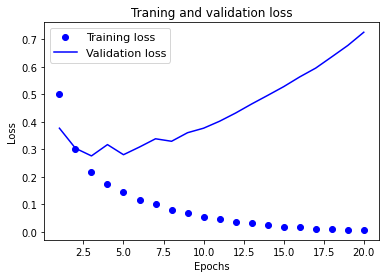

In [47]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

epochs = range(1, len(acc) + 1)

# 'bo'는 color = b, style = o 를 뜻함
plt.plot(epochs, loss, 'bo', label='Training loss')
# 'b'는 color = b, linestyle = '-'를 뜻함
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Traning and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(fontsize=11.2)

plt.show()